# Unit 5 - Financial Planning

In [98]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json

%matplotlib inline

In [52]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [53]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [54]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

In [55]:
# Fetch current BTC price
btc_price_data = requests.get(btc_url).json()
#print(json.dumps(btc_price_df, indent=4))
btc_price = btc_price_data['data']['1']['quotes']['USD']['price']
#print(btc_price)

# Fetch current ETH price
eth_price_data = requests.get(eth_url).json()
#print(json.dumps(eth_price, indent=4))
eth_price = eth_price_data['data']['1027']['quotes']['USD']['price']
#print(eth_price)

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $25106.40
The current value of your 5.3 ETH is $8686.01


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [56]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [57]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")


# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [71]:
# Format current date as ISO format
start_date = pd.Timestamp("2022-10-28", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2022-10-28", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"
#date = DateTime.today

# Get current closing prices for SPY and AGG
df_ticker = api.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df


# Reorganize the DataFrame
# Separate ticker data
df_ticker = df_ticker.drop(columns=['open', 'high', 'low', 'volume', 'trade_count', 'vwap'])
df_ticker = df_ticker.set_index('symbol')

# Concatenate the ticker DataFrames
# NOT NEEDED the way I did this

# Preview DataFrame
df_ticker

,close
symbol,
AGG,95.22
SPY,389.02


In [72]:
# Pick AGG and SPY close prices
agg_close_price = df_ticker.loc['AGG', 'close']
spy_close_price = df_ticker.loc['SPY', 'close']

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $95.22
Current SPY closing price: $389.02


In [73]:
# Compute the current value of shares
my_agg_value = my_agg * agg_close_price
my_spy_value = my_spy * spy_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $19451.00
The current value of your 200 AGG shares is $19044.00


### Savings Health Analysis

In [74]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto = my_btc_value + my_eth_value
shares = my_spy_value + my_agg_value

# Create savings DataFrame
df_savings = pd.DataFrame([crypto, shares], index=['crypto', 'shares'], columns=['amount'])

# Display savings DataFrame
display(df_savings)

,amount
crypto,33792.411
shares,38495.000


<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

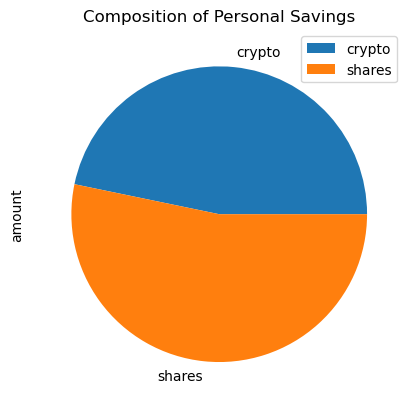

In [75]:
# Plot savings pie chart
df_savings.plot.pie(y="amount", title="Composition of Personal Savings")

In [76]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_current_savings = round(crypto + shares, 0) 

# Validate saving health
if total_current_savings > emergency_fund:
    display("Congratulations, you have enough money in your savings to cover an emergency fund!"),

elif total_current_savings == emergency_fund:  
    display("Congratulations, you have reached your savings goal!"),
          
elif total_current_savings < emergency_fund:
    deficit = emergency_fund - total_current_savings
    display(f"You have to save ${deficit} to reach your savings goal of ${emergency_fund}. You can do it!")
          


'Congratulations, you have enough money in your savings to cover an emergency fund!'

## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [77]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2017-10-28', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2022-10-28', tz='America/New_York').isoformat()

In [89]:
# Get 5 years' worth of historical data for SPY and AGG
df_portfolio = api.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Reorganize the DataFrame
# Separate ticker data
df_portfolio = df_portfolio.drop(columns=['trade_count', 'vwap'])
agg_data = df_portfolio[df_portfolio['symbol']=='AGG'].drop('symbol', axis=1)
spy_data = df_portfolio[df_portfolio['symbol']=='SPY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
df_stock_data = pd.concat([agg_data, spy_data],axis=1, keys=['AGG','SPY'])


# Display sample data
df_stock_data.head()

AGG                                        SPY  \
                             open     high      low   close   volume    open   
timestamp                                                                      
2017-10-30 04:00:00+00:00  109.43  109.560  109.360  109.54  2385203  257.07   
2017-10-31 04:00:00+00:00  109.52  109.550  109.440  109.47  3719883  257.18   
2017-11-01 04:00:00+00:00  109.17  109.410  109.170  109.29  2959362  258.04   
2017-11-02 04:00:00+00:00  109.35  109.495  109.331  109.35  2160492  257.41   
2017-11-03 04:00:00+00:00  109.48  109.480  109.290  109.45  1781239  257.77   

                                                              
                             high      low   close    volume  
timestamp                                                     
2017-10-30 04:00:00+00:00  257.60  256.410  256.80  54882217  
2017-10-31 04:00:00+00:00  257.44  256.805  257.12  60678916  
2017-11-01 04:00:00+00:00  258.43  257.070  257.50  54263336  
2017-11-02 04:00:00+00:00  257.75  256.190  257.62  56449535  
2017-11-03 04:00:00+00:00  258.50  257.300  258.45  62908639

In [92]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30yr = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*30)

In [99]:
# Printing the simulation input data
MC_30yr.portfolio_data.head()

AGG                                     \
                             open     high      low   close   volume   
timestamp                                                              
2017-10-30 04:00:00+00:00  109.43  109.560  109.360  109.54  2385203   
2017-10-31 04:00:00+00:00  109.52  109.550  109.440  109.47  3719883   
2017-11-01 04:00:00+00:00  109.17  109.410  109.170  109.29  2959362   
2017-11-02 04:00:00+00:00  109.35  109.495  109.331  109.35  2160492   
2017-11-03 04:00:00+00:00  109.48  109.480  109.290  109.45  1781239   

                                           SPY                           \
                          daily_return    open    high      low   close   
timestamp                                                                 
2017-10-30 04:00:00+00:00          NaN  257.07  257.60  256.410  256.80   
2017-10-31 04:00:00+00:00    -0.000639  257.18  257.44  256.805  257.12   
2017-11-01 04:00:00+00:00    -0.001644  258.04  258.43  257.070  257.50   
2017-11-02 04:00:00+00:00     0.000549  257.41  257.75  256.190  257.62   
2017-11-03 04:00:00+00:00     0.000914  257.77  258.50  257.300  258.45   

                                                  
                             volume daily_return  
timestamp                                         
2017-10-30 04:00:00+00:00  54882217          NaN  
2017-10-31 04:00:00+00:00  60678916     0.001246  
2017-11-01 04:00:00+00:00  54263336     0.001478  
2017-11-02 04:00:00+00:00  56449535     0.000466  
2017-11-03 04:00:00+00:00  62908639     0.003222

In [100]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_30yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\WADE BURGESS\Jupyter-Workspace\00-Homework\5-APIs-Homework\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.994839,1.002689,0.993611,1.010996,1.005667,1.005871,1.002877,1.008737,1.001835,0.991824,...,1.002569,0.987931,0.999504,1.016537,1.006404,0.991511,1.009775,0.989408,0.993956,1.002977
2,0.991969,1.017957,0.984883,0.997691,1.001742,1.014382,0.998922,1.010359,0.992419,1.001626,...,1.001669,0.980456,1.001762,1.020956,1.005997,0.991817,1.005836,0.987821,1.003037,1.006191
3,0.986784,1.038634,0.980779,0.974042,1.007386,1.011995,1.003351,1.005202,0.992029,0.996675,...,1.001803,0.971691,1.002143,1.006122,1.012448,1.001626,1.005998,0.990700,1.008397,0.999419
4,0.979881,1.038174,0.980709,0.984416,1.011182,1.007674,0.994714,1.003286,0.987925,1.000724,...,0.983238,0.962579,1.012899,0.997066,0.999822,0.992854,1.003559,0.990036,1.010168,0.997117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,0.686562,4.176211,3.126302,4.490258,2.456655,5.156857,13.838939,2.586261,1.368892,1.856382,...,2.965911,5.737962,1.886228,3.695606,2.538993,10.976358,4.640864,6.519753,2.310629,4.061689
7557,0.684627,4.169968,3.086997,4.433854,2.465683,5.171532,13.572049,2.626443,1.362834,1.841808,...,2.926302,5.737141,1.895515,3.701010,2.524921,11.059303,4.658518,6.505717,2.323901,4.060720
7558,0.683107,4.156499,3.101135,4.451460,2.455045,5.220362,13.422451,2.656302,1.367748,1.823705,...,2.946246,5.762450,1.887451,3.667178,2.541823,11.059873,4.578723,6.545219,2.322075,4.075939
7559,0.687813,4.164166,3.120469,4.468036,2.434988,5.236395,13.279000,2.665183,1.364132,1.826242,...,2.919762,5.799945,1.869819,3.676030,2.522130,11.050973,4.607658,6.620353,2.354705,4.056547


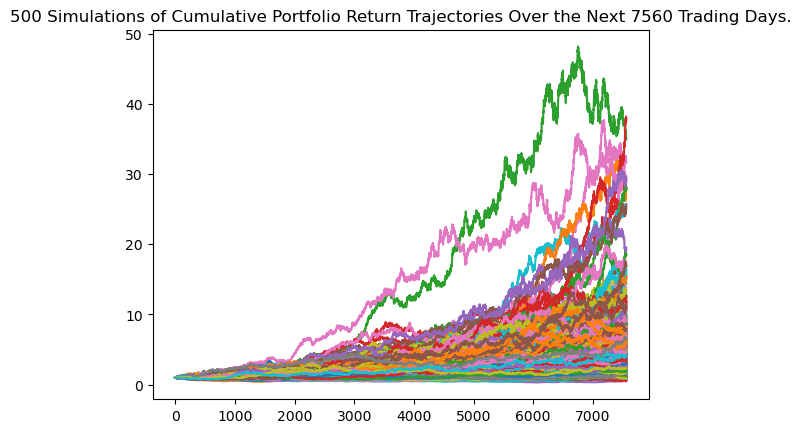

In [101]:
# Plot simulation outcomes
line_plot = MC_30yr.plot_simulation()

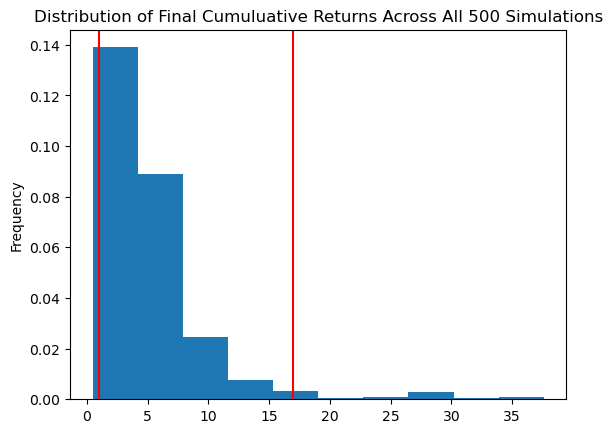

In [102]:
# Plot probability distribution and confidence intervals
dist_plot = MC_30yr.plot_distribution()

### Retirement Analysis

In [103]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_30yr.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              5.276848
std               4.736151
min               0.477266
25%               2.568175
50%               4.071275
75%               6.435701
max              37.602566
95% CI Lower      0.959158
95% CI Upper     16.946779
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [167]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*initial_investment, 2)
ci_upper = round(tbl[9]*initial_investment, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $19183.15 and $338935.59


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [165]:
# Set initial investment
initial_investment2 = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*initial_investment2, 2)
ci_upper = round(tbl[9]*initial_investment2, 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment2} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $28774.73 and $508403.38


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [150]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
## Higher initial investment of $60K, more weighted towards stocks
MC_5yr = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.15,.85],
    num_simulation = 500,
    num_trading_days = 252*5)

In [151]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_5yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\WADE BURGESS\Jupyter-Workspace\00-Homework\5-APIs-Homework\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001570,0.999444,0.995191,0.992368,1.019904,1.012722,1.001561,0.998589,0.990186,0.987147,...,0.997805,1.010357,1.001205,1.011683,1.016106,0.999078,1.003401,1.018112,0.997663,0.985840
2,0.993062,0.996837,1.002643,1.016674,1.020917,1.006651,0.983880,0.997588,1.006017,0.989694,...,1.001375,0.997075,0.993875,1.002926,1.018760,1.011130,1.019209,1.026095,1.011129,0.994303
3,0.984134,1.011209,1.015484,1.024704,1.041423,1.017758,0.976991,1.004217,1.008716,0.992335,...,0.992652,0.997387,1.013012,1.007864,0.995571,1.008891,1.029625,1.027556,0.999993,1.009803
4,0.974685,1.004209,1.005921,1.017024,1.030500,0.998266,0.982703,1.007683,1.005754,0.994066,...,0.981526,1.002121,1.006121,0.995207,0.999076,1.010793,1.038094,1.048571,1.020870,1.010093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.901159,1.856224,1.456961,0.963633,1.790433,1.638835,1.044302,1.326549,1.269482,1.717601,...,1.409826,1.977649,1.486759,0.906296,0.563660,1.528642,2.035090,1.126244,1.398201,2.556147
1257,1.887545,1.834802,1.471392,0.948279,1.787081,1.649516,1.041379,1.324286,1.277659,1.737578,...,1.403993,1.970976,1.504274,0.908988,0.558864,1.527452,2.025921,1.119219,1.371374,2.643257
1258,1.865018,1.837625,1.475657,0.928825,1.766825,1.669471,1.029325,1.313516,1.284014,1.712203,...,1.408503,1.958477,1.499675,0.904136,0.547469,1.545339,2.019033,1.128048,1.385365,2.629537
1259,1.863846,1.815326,1.471501,0.938483,1.768235,1.666558,1.011815,1.303154,1.280491,1.721863,...,1.414738,1.983136,1.497096,0.909659,0.539664,1.531640,1.997441,1.110342,1.412931,2.581196


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

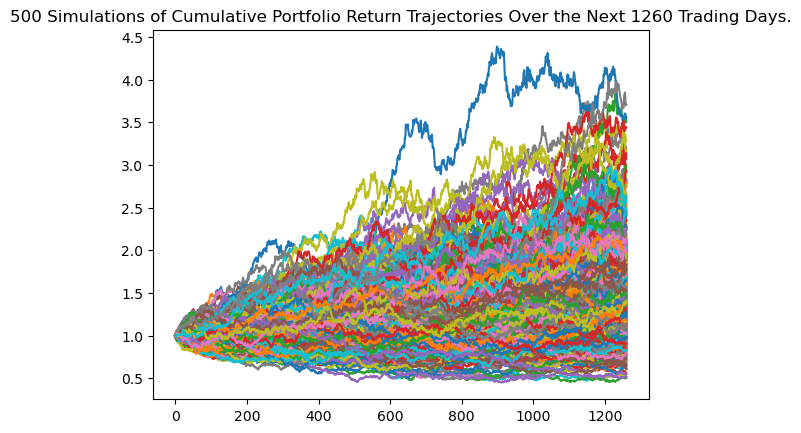

In [152]:
# Plot simulation outcomes
MC_5yr.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

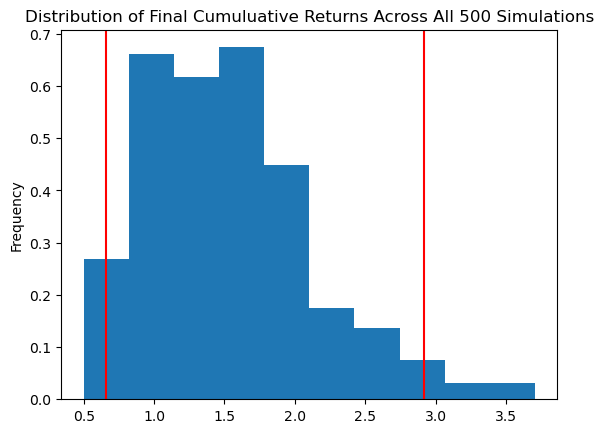

In [153]:
# Plot probability distribution and confidence intervals
MC_5yr.plot_distribution()

In [154]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_5yr = MC_5yr.summarize_cumulative_return()

# Print summary statistics
print(tbl_5yr)

count           500.000000
mean              1.527020
std               0.591399
min               0.501839
25%               1.074627
50%               1.469575
75%               1.875696
max               3.705004
95% CI Lower      0.656986
95% CI Upper      2.919394
Name: 1260, dtype: float64


In [162]:
# Set initial investment
initial_investment_5yr = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tbl_5yr[8]*initial_investment_5yr, 0)
ci_upper_five = round(tbl_5yr[9]*initial_investment_5yr, 0)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_5yr} in the portfolio with"
      f" 85% invested in stocks over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio with 85% invested in stocks over the next 5 years will end within in the range of $39419.0 and $175164.0


### Ten Years Retirement Option

In [156]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
## Initial Investment of $60K, same weighting as original 30 year analysis
MC_10yr = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.40,.60],
    num_simulation = 500,
    num_trading_days = 252*10)

In [157]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_10yr.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


C:\Users\WADE BURGESS\Jupyter-Workspace\00-Homework\5-APIs-Homework\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.003401,0.983467,1.014695,0.990356,0.995669,1.006785,1.007070,1.000441,0.999590,0.995556,...,1.010516,0.998068,1.013829,0.993353,1.012457,0.988817,1.009310,1.002448,0.999130,1.002580
2,1.003593,0.983107,1.012597,1.006000,0.991398,1.004437,1.004778,0.995017,1.003272,0.990084,...,1.006059,1.001248,1.015382,0.980000,1.009606,1.001316,1.008624,1.005248,1.016834,1.003475
3,0.999816,0.979185,1.016275,1.007680,0.999696,1.025795,0.999726,1.005573,1.002345,0.993830,...,1.007322,1.007748,1.004558,0.984267,0.986644,1.002105,0.995894,0.997452,1.012515,1.001660
4,0.987957,0.964087,1.006714,0.987369,0.993212,1.036488,1.012269,0.991105,1.007340,1.008606,...,1.003041,1.009801,0.992735,0.993890,0.985204,1.004861,0.977866,1.002119,1.002949,1.009086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.862274,1.192795,0.853404,1.119116,0.837793,1.934519,1.308196,1.245330,2.520305,1.527051,...,1.071516,0.705270,1.930625,1.540687,0.772684,1.162904,1.411502,1.627185,1.512192,1.093860
2517,1.867147,1.193712,0.865136,1.126029,0.842295,1.949557,1.294082,1.239174,2.558046,1.513765,...,1.067790,0.716727,1.946222,1.530667,0.779162,1.168730,1.391302,1.650342,1.518425,1.093317
2518,1.880430,1.208988,0.868108,1.121407,0.841449,1.937366,1.304389,1.245428,2.550823,1.514938,...,1.063437,0.719767,1.956725,1.527877,0.779525,1.174973,1.409526,1.655385,1.516590,1.103154
2519,1.882856,1.227463,0.869602,1.120298,0.840263,1.936081,1.276647,1.258253,2.565592,1.498161,...,1.060334,0.727449,1.945832,1.518268,0.782228,1.172889,1.409462,1.663888,1.533137,1.097138


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 2520 Trading Days.'}>

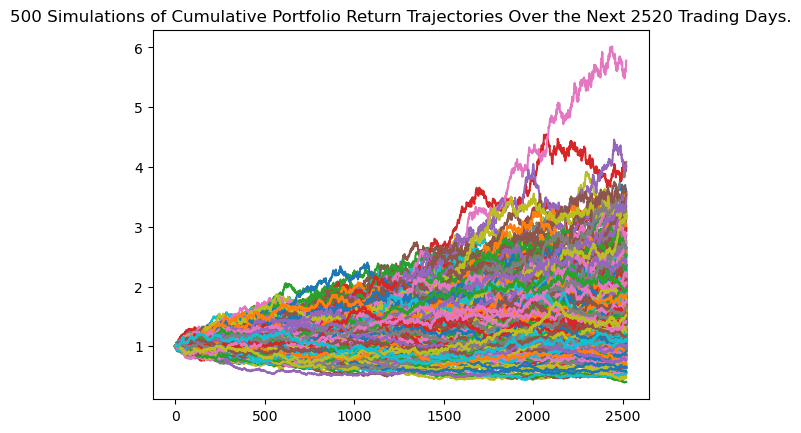

In [158]:
# Plot simulation outcomes
MC_10yr.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

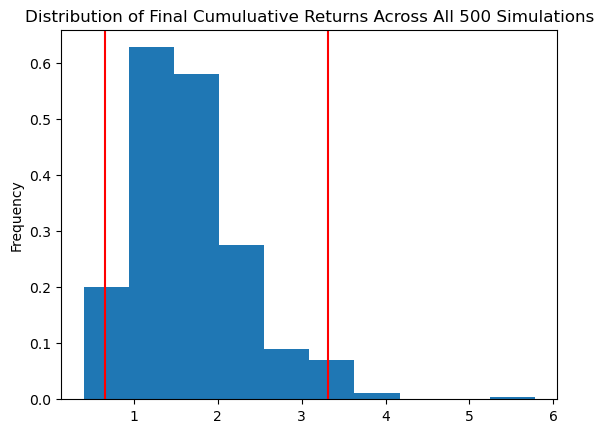

In [159]:
# Plot probability distribution and confidence intervals
MC_10yr.plot_distribution()

In [160]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_10yr = MC_10yr.summarize_cumulative_return()

# Print summary statistics
print(tbl_10yr)

count           500.000000
mean              1.654404
std               0.677415
min               0.402942
25%               1.183489
50%               1.533099
75%               1.993136
max               5.779890
95% CI Lower      0.651052
95% CI Upper      3.314256
Name: 2520, dtype: float64


In [163]:
# Set initial investment
initial_investment_10yr = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(tbl_10yr[8]*initial_investment_10yr, 0)
ci_upper_ten = round(tbl_10yr[9]*initial_investment_10yr, 0)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment_10yr} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $39063.0 and $198855.0
